<a href="https://colab.research.google.com/github/Aditya-77/Major_Project_component/blob/main/Final_segmentation_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data description & preparation <a name="1"></a>

## 1.1 Data Visualizations <a name="1.1"></a>

In [ ]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

DATA_ROOT = "../input/landcoverai"

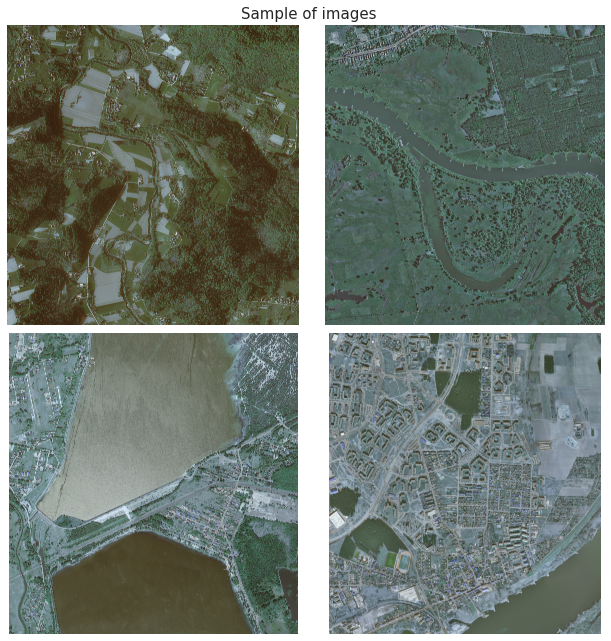

In [ ]:
images_list = list(glob.glob(os.path.join(DATA_ROOT, "images", "*.tif")))
samples = [0,1,2,3]
fig, ax = plt.subplots(figsize = (9,9), nrows = 2, ncols =2)
for i, sample in enumerate(samples):
    r,c = divmod(i,2)
    ax[r,c].imshow(cv2.imread(images_list[sample])/255)
    ax[r,c].axis("off")
plt.suptitle("Sample of images", fontsize = 15)
plt.tight_layout(pad=0.8)
plt.savefig("Samples.png")
plt.show()

## 1.2 Image Cropping <a name="1.2"></a>

In [ ]:
# Splitting the images
from utils import split_images

IMAGE_SIZE = 512
split_images(TARGET_SIZE = IMAGE_SIZE)

Splitting the images...

Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A

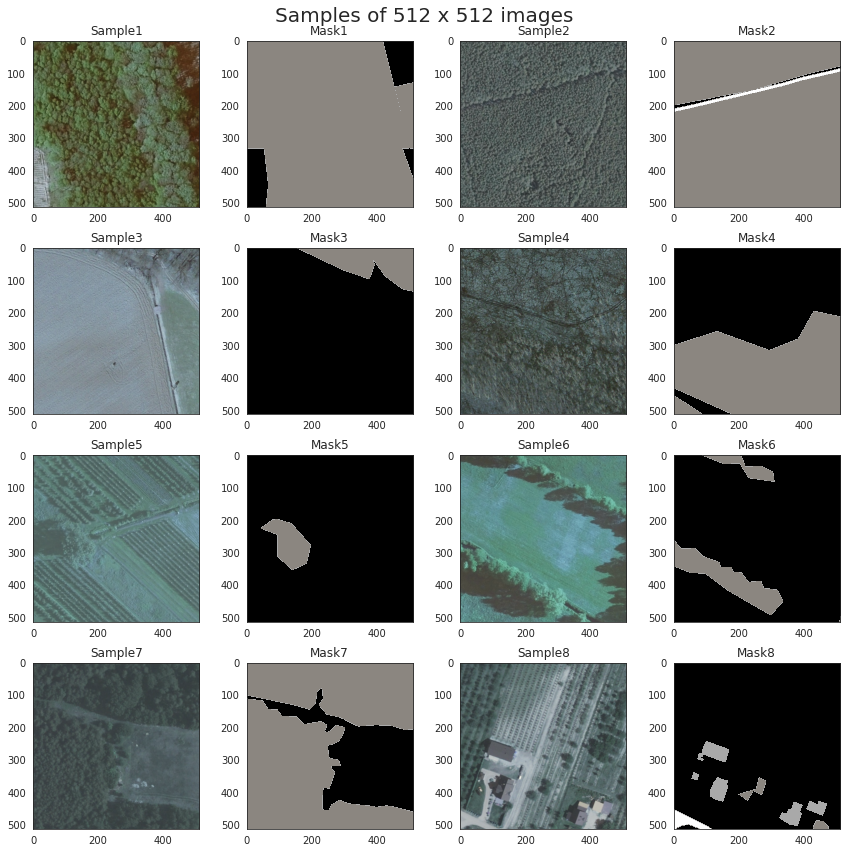

In [ ]:
from utils import visualize_dataset

visualize_dataset(num_samples = 8, w = 12, h = 12, pad = 1.4,
                 save_title = "Visualize_dataset", indices = [0,1,17,20,29,5,6,7])

In [ ]:
import torch
from torch.utils.data import DataLoader
from utils import SegmentationDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set,batch_size = 8,num_workers =2)

class_dist = {"background":0, "building":0,
                     "woodland":0, "water":0, "road":0}
label_mapping = {0: "background", 1: "building",
                2: "woodland", 3: "water", 4: "road"}

for img,mask in train_dloader:
    for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

Using the whole train set --> 7470


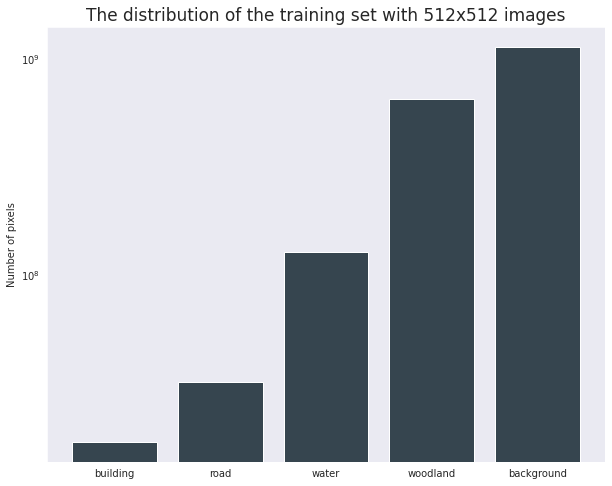

In [ ]:
temp_list = sorted([(l,s) for (l,s) in class_dist.items()], key= lambda x: x[1])
labels = [x[0] for x in temp_list]
support = [x[1] for x in temp_list]

sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(labels, support, color = "#36454F")
ax.set_yscale("log")
ax.set_title("The distribution of the training set with 512x512 images",
            fontsize = 17)
ax.set_ylabel("Number of pixels")
plt.savefig("Barplt.png")
plt.show()

## 1.2 Data Augmentation <a name="1.2"></a>

In [ ]:
import albumentations as A

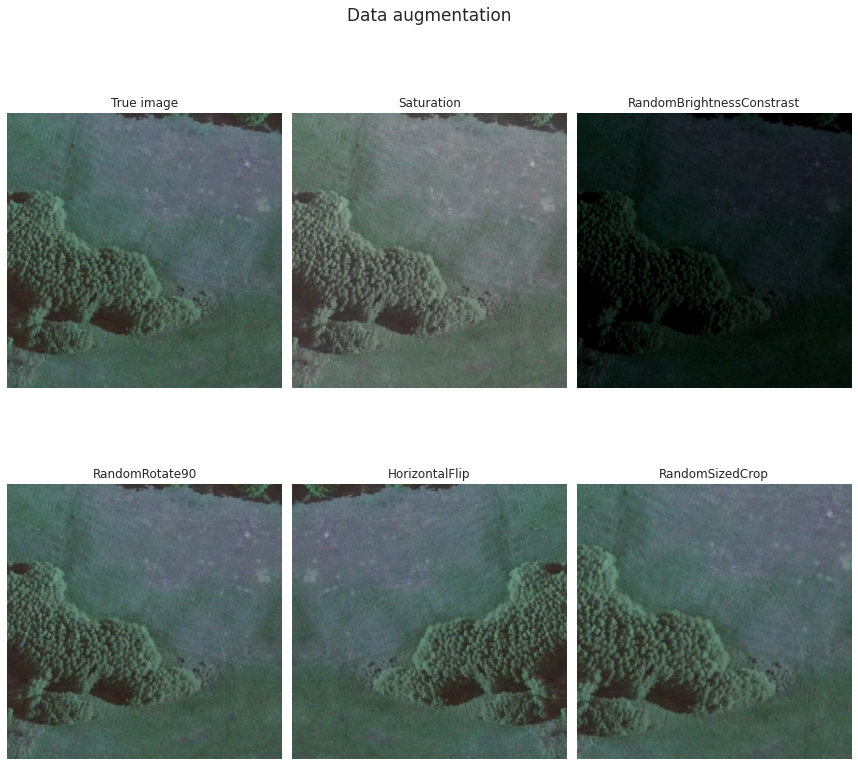

In [ ]:
# Transformations
transforms = [A.HueSaturationValue(40,40,30,p=1),
             A.RandomBrightnessContrast(p=1,brightness_limit = 0.2, contrast_limit = 0.5),
             A.RandomRotate90(p=1), A.HorizontalFlip(p=1),
              A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)]
transforms_names = ["Saturation", "RandomBrightnessConstrast",
                   "RandomRotate90", "HorizontalFlip", "RandomSizedCrop"]

# Read the NUM_SAMPLE sample in the training set
NUM_SAMPLE = 4
trainpath_list = list(glob.glob(os.path.join(os.getcwd(),"output", "*.jpg")))
img = cv2.imread(trainpath_list[NUM_SAMPLE])

fig, ax = plt.subplots(figsize = (12,12), nrows = 2, ncols = 3)

ax[0,0].imshow(img)
ax[0,0].axis("off")
ax[0,0].set_title("True image")
count = 0

for i in range(2):
    for j in range(3):
        if i+j == 0:
            ax[i,j].imshow(img)
            ax[i,j].axis("off")
            ax[i,j].set_title("True image")
        else:
            transformed_img = transforms[count](image = img)["image"]
            ax[i,j].imshow(transformed_img)
            ax[i,j].axis("off")
            ax[i,j].set_title(transforms_names[count])
            count+=1
plt.suptitle("Data augmentation", fontsize = 17)
plt.tight_layout(pad = 1)
plt.savefig("augmentations.png")
plt.show()

# 3. Experiments <a name="3"></a>

In [ ]:
# Configuring the set of transformations
transforms = A.Compose([
    A.OneOf([
        A.HueSaturationValue(40,40,30,p=1),
        A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                  contrast_limit = 0.5)], p = 0.5),
    A.OneOf([
        A.RandomRotate90(p=1),
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
    ], p = 0.5)])

In [ ]:
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6b58ed456281f7b054466bdf2de96b9927be72cf5333026dd28efc826c163f7b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=1aba7bf419efbe67fe074079a0d85bcb3037e90894f8f27cba5aeaabc805737e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
target_names = np.array(["background", "building", "woodland", "water", "road"])

# Loss function - Mean IoU loss
loss_fn = smp.losses.JaccardLoss(mode = "multiclass",
                                classes = 5).to(device)

# Hyperparameters
batch_size = 8
epochs = 80
lr = 5e-5

# Preparing datasets and DataLoaders
train_set = SegmentationDataset(mode = "train", transforms = transforms,
                               ratio = 0.9)
test_set = SegmentationDataset(mode = "test")
val_set = SegmentationDataset(mode = "val", ratio = 0.7)

train_dloader = DataLoader(train_set, batch_size = batch_size,
                           shuffle = True, num_workers = 2)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2)
val_dloader = DataLoader(val_set, batch_size=batch_size, num_workers = 2)

Using the 90.00% of the initial train set --> 6723|7470
Using the whole test set --> 1602
Using the 70.00% of the initial val set --> 1121|1602


In [ ]:
from utils import training_loop

## 3.3 UNet with Resnet encoder <a name="3.3"></a>



In [ ]:
model = smp.Unet(encoder_name = "resnet50",
                encoder_weights = "imagenet",
                classes = 5).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training of UNet with Resnet encoder starts!
Using loss as stopping criterion.

Epoch: 1/80     Training Loss: 0.5337     Validation Loss: 0.3547
Validation loss decreased (inf --> 0.354692).  Saving model ...
Epoch: 2/80     Training Loss: 0.3527     Validation Loss: 0.2861
Validation loss decreased (0.354692 --> 0.286067).  Saving model ...
Epoch: 3/80     Training Loss: 0.2969     Validation Loss: 0.2624
Validation loss decreased (0.286067 --> 0.262418).  Saving model ...
Epoch: 4/80     Training Loss: 0.2837     Validation Loss: 0.2764
EarlyStopping counter: 1 out of 5
Epoch: 5/80     Training Loss: 0.2621     Validation Loss: 0.2575
Validation loss decreased (0.262418 --> 0.257516).  Saving model ...
Epoch: 6/80     Training Loss: 0.2648     Validation Loss: 0.2458
Validation loss decreased (0.257516 --> 0.245785).  Saving model ...
Epoch: 7/80     Training Loss: 0.2415     Validation Loss: 0.2309
Validation loss decreased (0.245785 --> 0.230921).  Saving model ...
Epoch: 8/80    

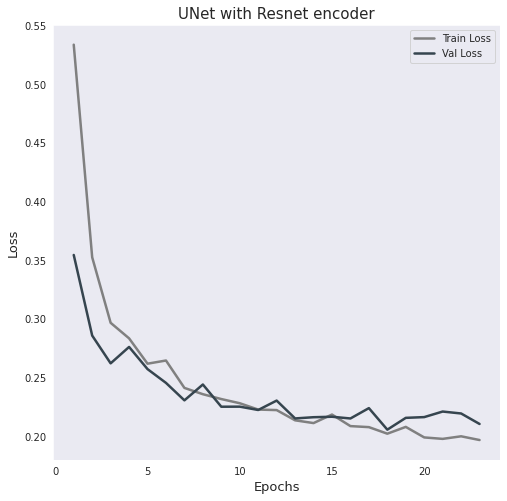


 Training completed in 2.0 h 36.0 m 50.88 s.


In [ ]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 5, verbose = True, model_title = "UNet with Resnet encoder", save = True,
             stopping_criterion = "loss")

In [ ]:
# Evaluation - Accuracy + MIoU
from utils import segmentation_test_loop
from utils import class_report
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                        device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

          precision          recall          f1-score          support

background          0.96          0.95          0.96          239926712
building          0.91          0.84          0.87          3956554
woodland          0.93          0.95          0.94          144170112
water          0.94          0.96          0.95          24388122
road          0.79          0.75          0.77          7513188

- Total accuracy:0.9461

- Mean IoU: 0.8208

- Class probs
background:0.999
building:0.993
woodland:0.999
water:0.999
road:0.992


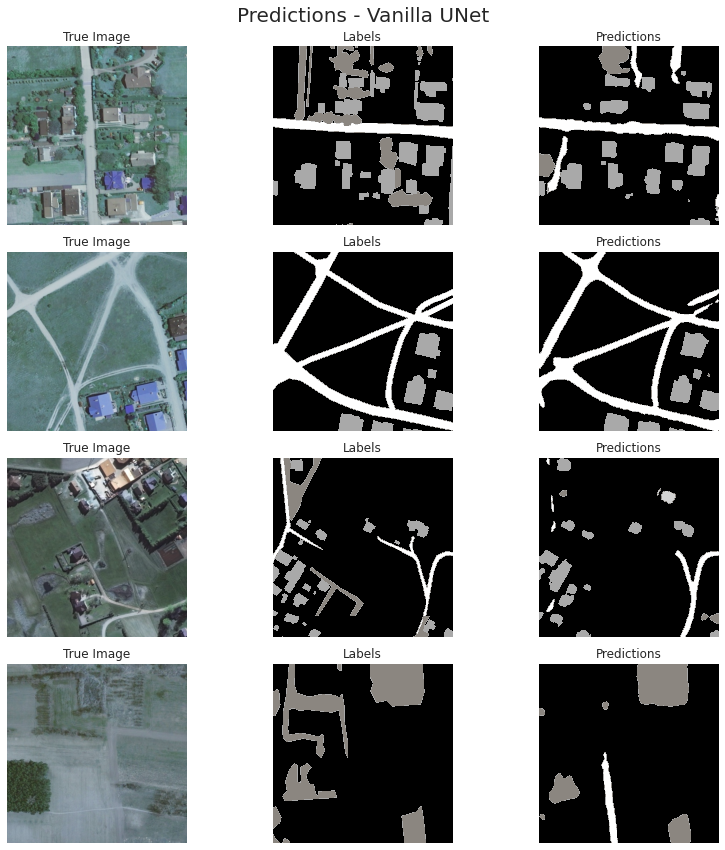

In [ ]:
from utils import visualize_preds
visualize_preds(model, test_set, title = "Predictions - Vanilla UNet",
               save_title = "UNet", h = 12, w = 12, indices = [959,960,1472,1576])

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=508b4c0f7ec9a35b034bb1784bb166e51ae5b23ecc91f66bb792d270987d3762
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=623a1324d1807d62b0a408cbe70ce567eebcc4440d0ce3560c1b56db98b29c34
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import torch
import segmentation_models_pytorch as smp

def load_segmentation_model(checkpoint_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the model
    model = smp.Unet(encoder_name="resnet50", encoder_weights=None, classes=5).to(device)

    # Load the entire model from the checkpoint
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))

    # Set the model to evaluation mode
    model.eval()

    return model

# Path to your segmentation model checkpoint
segmentation_checkpoint_path = "/content/drive/MyDrive/saved_models/checkpoint.pt"

# Load segmentation model
segmentation_model = load_segmentation_model(segmentation_checkpoint_path)

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine device
generator = GeneratorResNet().to(device)  # Move generator to the appropriate device
generator.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/generator.pth", map_location=device))



<All keys matched successfully>

In [71]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def process_image(image_path, generator, segmentation_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Generate high-resolution image
    with torch.no_grad():
        generator.eval()
        segmentation_model.eval()
        generated_image = generator(input_tensor)

    # Perform segmentation on the original input image
    with torch.no_grad():
        segmentation_model.eval()
        segmentation_map = torch.argmax(segmentation_model(generated_image), dim=1)
        segmentation_map = segmentation_map.squeeze().cpu().numpy()

    return generated_image.squeeze().cpu().numpy(), segmentation_map


# Example usage:
image_path = "/content/drive/MyDrive/Final Project/chips/images/N-34-97-C-b-1-2_10.png"
generated_image, segmentation_map = process_image(image_path, generator, segmentation_model)


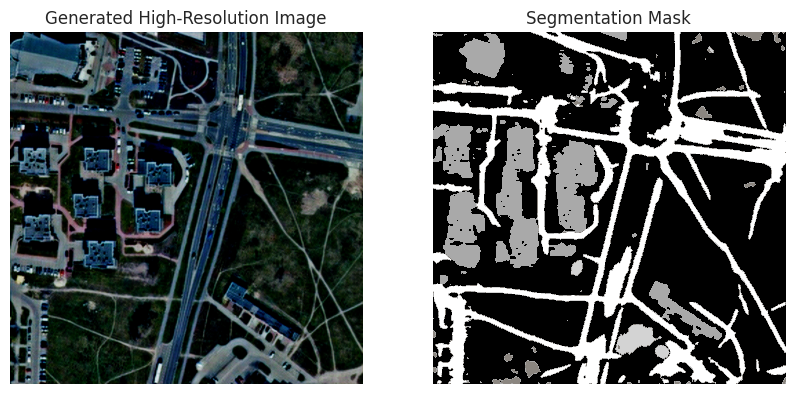

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def display_images(generated_image, segmentation_map, label_cmap):
    # Move the color channels to the last dimension
    generated_image = np.transpose(generated_image, (1, 2, 0))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the generated high-resolution image
    axes[0].imshow(generated_image)
    axes[0].set_title('Generated High-Resolution Image')
    axes[0].axis('off')

    # Display the segmentation mask with custom colors
    axes[1].imshow(segmentation_map, cmap=label_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    plt.show()

# Example usage:
display_images(generated_image, segmentation_map, labels_cmap)
